# HR Analytics - Analyse des causes de démission

## Objectif
Identifier les causes racines du turnover élevé chez TechNova Partners et proposer des leviers d'action.

## 1. Chargement et Inspection des Données

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [ ]:
# Chargement des fichiers
df_sirh = pd.read_csv('extrait_sirh.csv')
df_eval = pd.read_csv('extrait_eval.csv')
df_sondage = pd.read_csv('extrait_sondage.csv')

print("Dimensions SIRH:", df_sirh.shape)
print("Dimensions Eval:", df_eval.shape)
print("Dimensions Sondage:", df_sondage.shape)

Dimensions SIRH: (1470, 12)
Dimensions Eval: (1470, 10)
Dimensions Sondage: (1470, 12)


## 2. Nettoyage et Fusion des Données

Nous devons uniformiser les clés de jointure :
- `df_sirh` : `id_employee` est déjà un entier.
- `df_eval` : `eval_number` est sous la forme "E_XXX", nous devons extraire le nombre.
- `df_sondage` : `code_sondage` doit être converti en entier.

In [ ]:
# Nettoyage des clés

# 1. SIRH : Renommer pour avoir une clé commune 'id'
df_sirh = df_sirh.rename(columns={'id_employee': 'id'})

# 2. Eval : Nettoyer 'eval_number' (ex: 'E_1' -> 1)
df_eval['id'] = df_eval['eval_number'].astype(str).str.replace('E_', '').astype(int)

# 3. Sondage : Renommer et s'assurer que c'est un int
df_sondage = df_sondage.rename(columns={'code_sondage': 'id'})
df_sondage['id'] = pd.to_numeric(df_sondage['id'], errors='coerce').astype('Int64')

# Vérification des doublons de clés
print("Doublons ID SIRH:", df_sirh['id'].duplicated().sum())
print("Doublons ID Eval:", df_eval['id'].duplicated().sum())
print("Doublons ID Sondage:", df_sondage['id'].duplicated().sum())

Doublons ID SIRH: 0
Doublons ID Eval: 0
Doublons ID Sondage: 0


In [ ]:
# Fusion des dataframes
# On utilise un inner join pour ne garder que les employés présents dans les 3 bases
df_merged = df_sirh.merge(df_eval, on='id', how='inner')
df_merged = df_merged.merge(df_sondage, on='id', how='inner')

print("Dimensions après fusion:", df_merged.shape)
df_merged.head()

Dimensions après fusion: (1470, 33)


,id,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,2,3,2,4,1,1,E_1,3,Oui,11 %,Oui,0,0,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,3,2,2,2,4,3,E_2,4,Non,23 %,Non,1,3,1,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0,4,2,1,3,2,3,E_4,3,Oui,15 %,Oui,0,3,1,2,2,Autre,Y,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7,4,3,1,3,3,3,E_5,3,Oui,11 %,Non,0,3,1,3,4,Infra & Cloud,Y,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2,1,3,1,2,4,3,E_7,3,Non,12 %,Non,1,3,1,2,1,Transformation Digitale,Y,Occasionnel,2,2


In [ ]:
# Vérification des valeurs manquantes après fusion
df_merged.isnull().sum()[df_merged.isnull().sum() > 0]

Series([], dtype: int64)

## 3. Analyse Exploratoire (EDA)
### 3.1 Analyse de la variable cible (Démission)

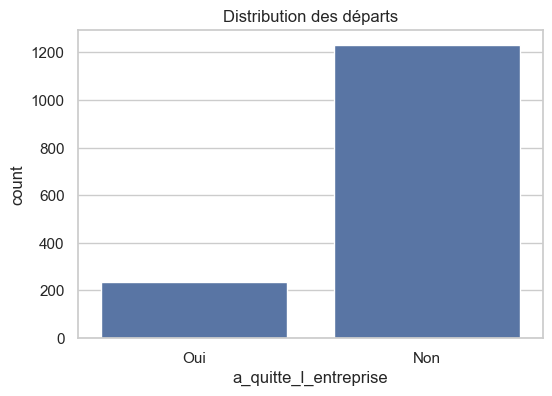

a_quitte_l_entreprise
Non    0.838776
Oui    0.161224
Name: proportion, dtype: float64


In [ ]:
target_col = 'a_quitte_l_entreprise'

plt.figure(figsize=(6, 4))
sns.countplot(data=df_merged, x=target_col)
plt.title("Distribution des départs")
plt.show()

print(df_merged[target_col].value_counts(normalize=True))

### 3.2 Statistiques Descriptives

In [ ]:
# Séparation des variables numériques et catégorielles
num_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_merged.select_dtypes(include=['object']).columns.tolist()

# Retirer 'id' des variables numériques
if 'id' in num_cols:
    num_cols.remove('id')

print("Variables numériques:", len(num_cols))
print("Variables catégorielles:", len(cat_cols))

# Statistiques descriptives pour les numériques
df_merged[num_cols].describe()

Variables numériques: 21
Variables catégorielles: 11


,age,revenu_mensuel,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
count,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,6502.931293,2.693197,80.0,11.279592,7.008163,4.229252,2.721769,2.729932,2.063946,2.728571,2.712245,2.761224,3.153741,0.793878,2.799320,1.0,9.192517,2.912925,2.187755,4.123129
std,9.135373,4707.956783,2.498009,0.0,7.780782,6.126525,3.623137,1.093082,0.711561,1.106940,1.102846,1.081209,0.706476,0.360824,0.852077,1.289271,0.0,8.106864,1.024165,3.222430,3.568136
min,18.000000,1009.000000,0.000000,80.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000
25%,30.000000,2911.000000,1.000000,80.0,6.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,3.000000,0.000000,2.000000,1.0,2.000000,2.000000,0.000000,2.000000
50%,36.000000,4919.000000,2.000000,80.0,10.000000,5.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,1.000000,3.000000,1.0,7.000000,3.000000,1.000000,3.000000
75%,43.000000,8379.000000,4.000000,80.0,15.000000,9.000000,7.000000,4.000000,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,1.000000,3.000000,1.0,14.000000,4.000000,3.000000,7.000000
max,60.000000,19999.000000,9.000000,80.0,40.000000,40.000000,18.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,3.000000,6.000000,1.0,29.000000,5.000000,15.000000,17.000000


### 3.3 Analyse des variables numériques vs Démission
Comparons les distributions des variables numériques pour ceux qui sont partis vs ceux qui sont restés.

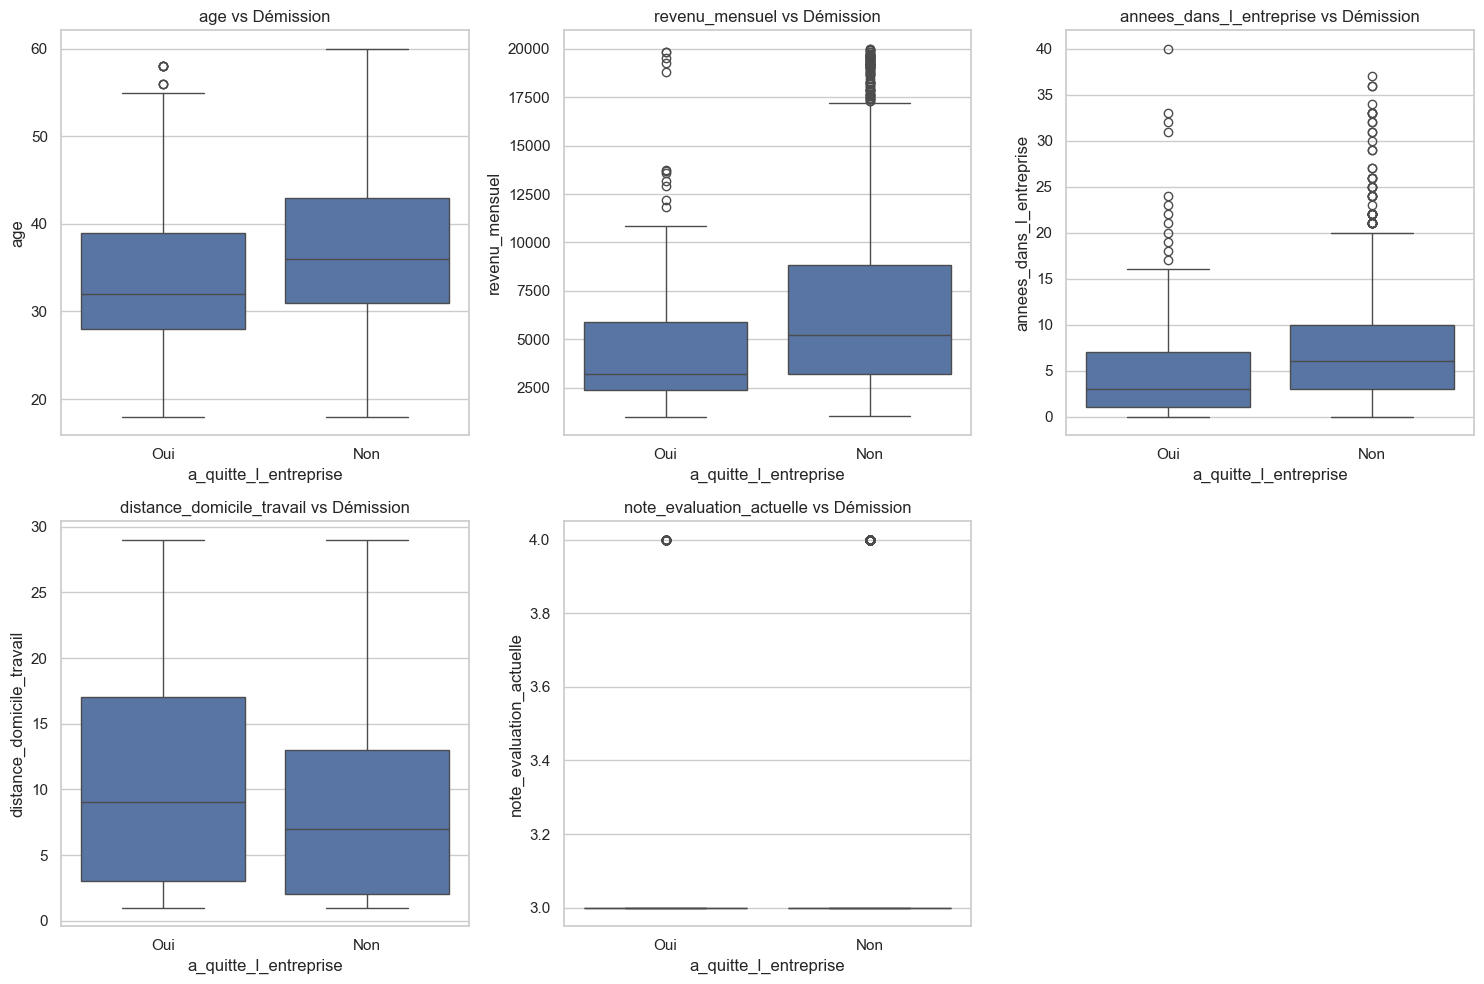

In [ ]:
# Sélection de quelques variables clés pour l'analyse
key_num_cols = ['age', 'revenu_mensuel', 'annees_dans_l_entreprise', 'distance_domicile_travail', 'note_evaluation_actuelle']

plt.figure(figsize=(15, 10))
for i, col in enumerate(key_num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df_merged, x=target_col, y=col)
    plt.title(f"{col} vs Démission")
plt.tight_layout()
plt.show()

### 3.4 Analyse des variables catégorielles vs Démission

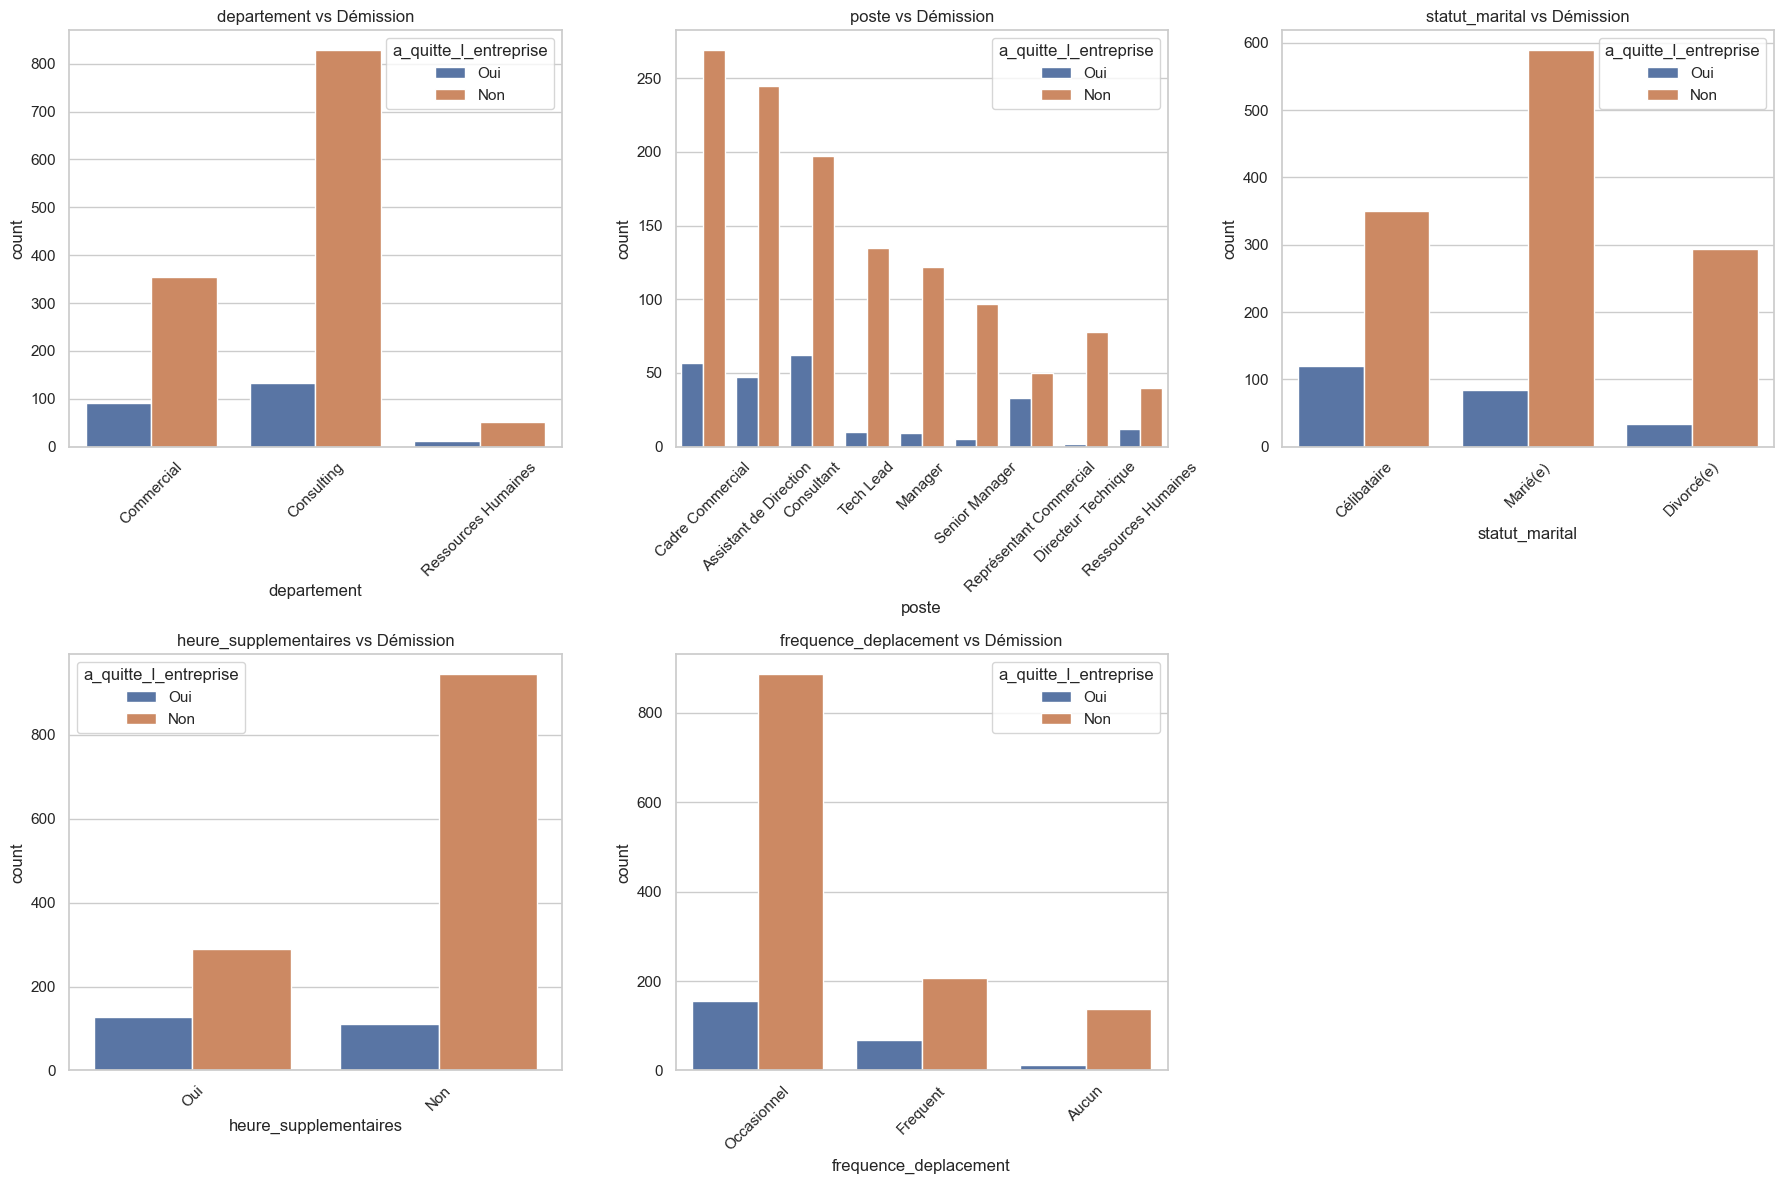

In [ ]:
key_cat_cols = ['departement', 'poste', 'statut_marital', 'heure_supplementaires', 'frequence_deplacement']

plt.figure(figsize=(18, 12))
for i, col in enumerate(key_cat_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df_merged, x=col, hue=target_col)
    plt.title(f"{col} vs Démission")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.5 Analyse de la Satisfaction

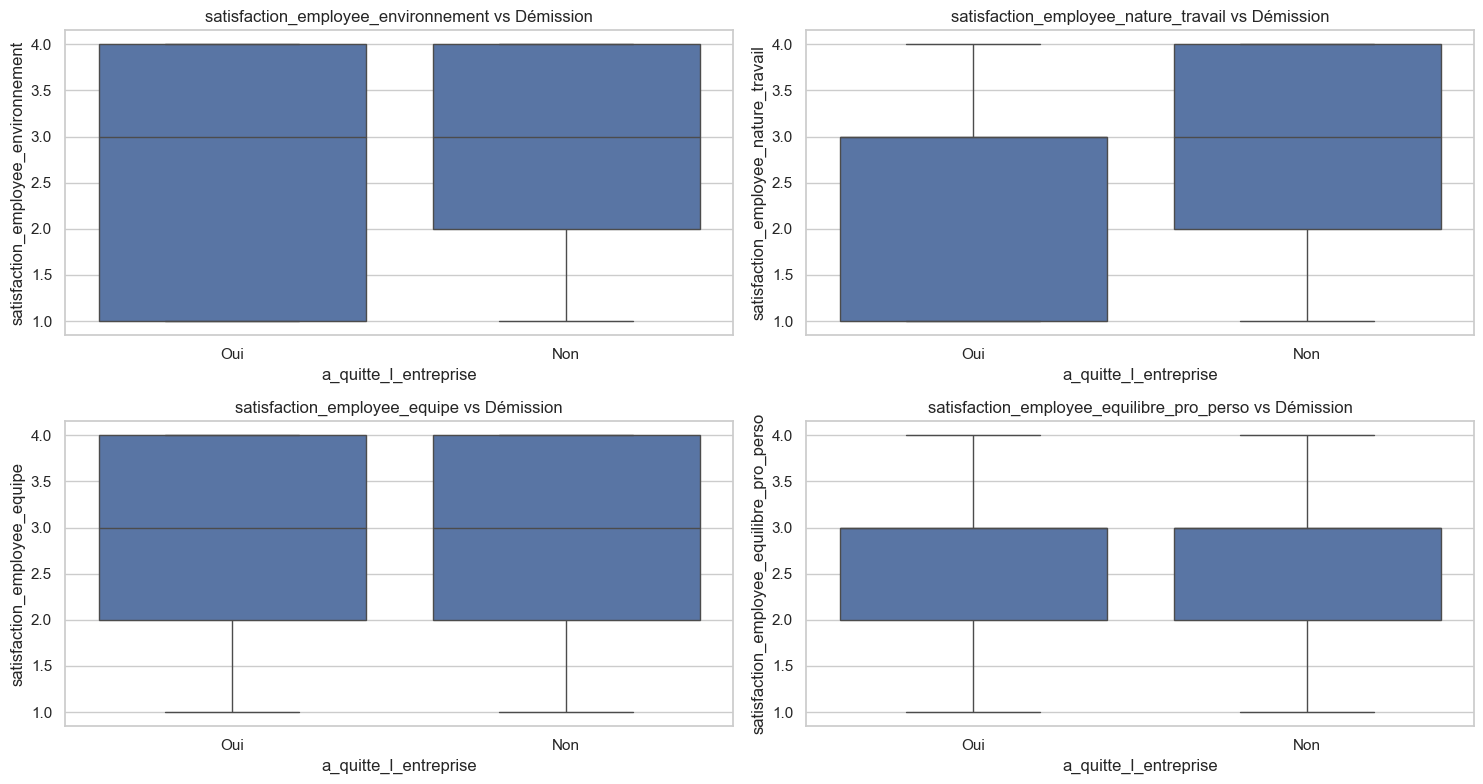

In [ ]:
satisfaction_cols = [col for col in df_merged.columns if 'satisfaction' in col]

plt.figure(figsize=(15, 8))
for i, col in enumerate(satisfaction_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df_merged, x=target_col, y=col)
    plt.title(f"{col} vs Démission")
plt.tight_layout()
plt.show()

## 4. Feature Engineering
### 4.1 Préparation de la variable cible

In [ ]:
# Variable cible : conversion en binaire (Oui -> 1, Non -> 0)
df_merged['target'] = (df_merged['a_quitte_l_entreprise'] == 'Oui').astype(int)
print(df_merged['target'].value_counts())

target
0    1233
1     237
Name: count, dtype: int64


### 4.2 Identification des types de variables

In [ ]:
# Colonnes à exclure
cols_to_exclude = ['id', 'a_quitte_l_entreprise', 'eval_number', 'target']

# Séparer les variables numériques et catégorielles
all_cols = [col for col in df_merged.columns if col not in cols_to_exclude]

# Variables numériques
num_cols = df_merged[all_cols].select_dtypes(include=[np.number]).columns.tolist()

# Variables catégorielles
cat_cols = df_merged[all_cols].select_dtypes(include=['object']).columns.tolist()

print(f"Variables numériques ({len(num_cols)}): {num_cols}")
print(f"\nVariables catégorielles ({len(cat_cols)}): {cat_cols}")

Variables numériques (21): ['age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'distance_domicile_travail', 'niveau_education', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']

Variables catégorielles (9): ['genre', 'statut_marital', 'departement', 'poste', 'heure_supplementaires', 'augementation_salaire_precedente', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement']


### 4.2.b Suppression des variables constantes
Certaines variables peuvent avoir la même valeur pour tous les employés (variance nulle). Elles n'apportent aucune information au modèle et doivent être supprimées.

In [ ]:
# Identification des variables constantes
const_cols = [col for col in df_merged.columns if df_merged[col].nunique() <= 1]
print(f"Variables constantes identifiées : {const_cols}")

# Suppression
if const_cols:
    df_merged = df_merged.drop(columns=const_cols)
    print("Variables supprimées.")
    
    # Mise à jour des listes de variables
    num_cols = [c for c in num_cols if c not in const_cols]
    cat_cols = [c for c in cat_cols if c not in const_cols]
    all_cols = [c for c in all_cols if c not in const_cols]
    print(f"Nouvelles dimensions : {df_merged.shape}")

Variables constantes identifiées : ['nombre_heures_travailless', 'nombre_employee_sous_responsabilite', 'ayant_enfants']
Variables supprimées.
Nouvelles dimensions : (1470, 31)


### 4.3 Analyse des corrélations (Pearson)
Pour les variables numériques uniquement

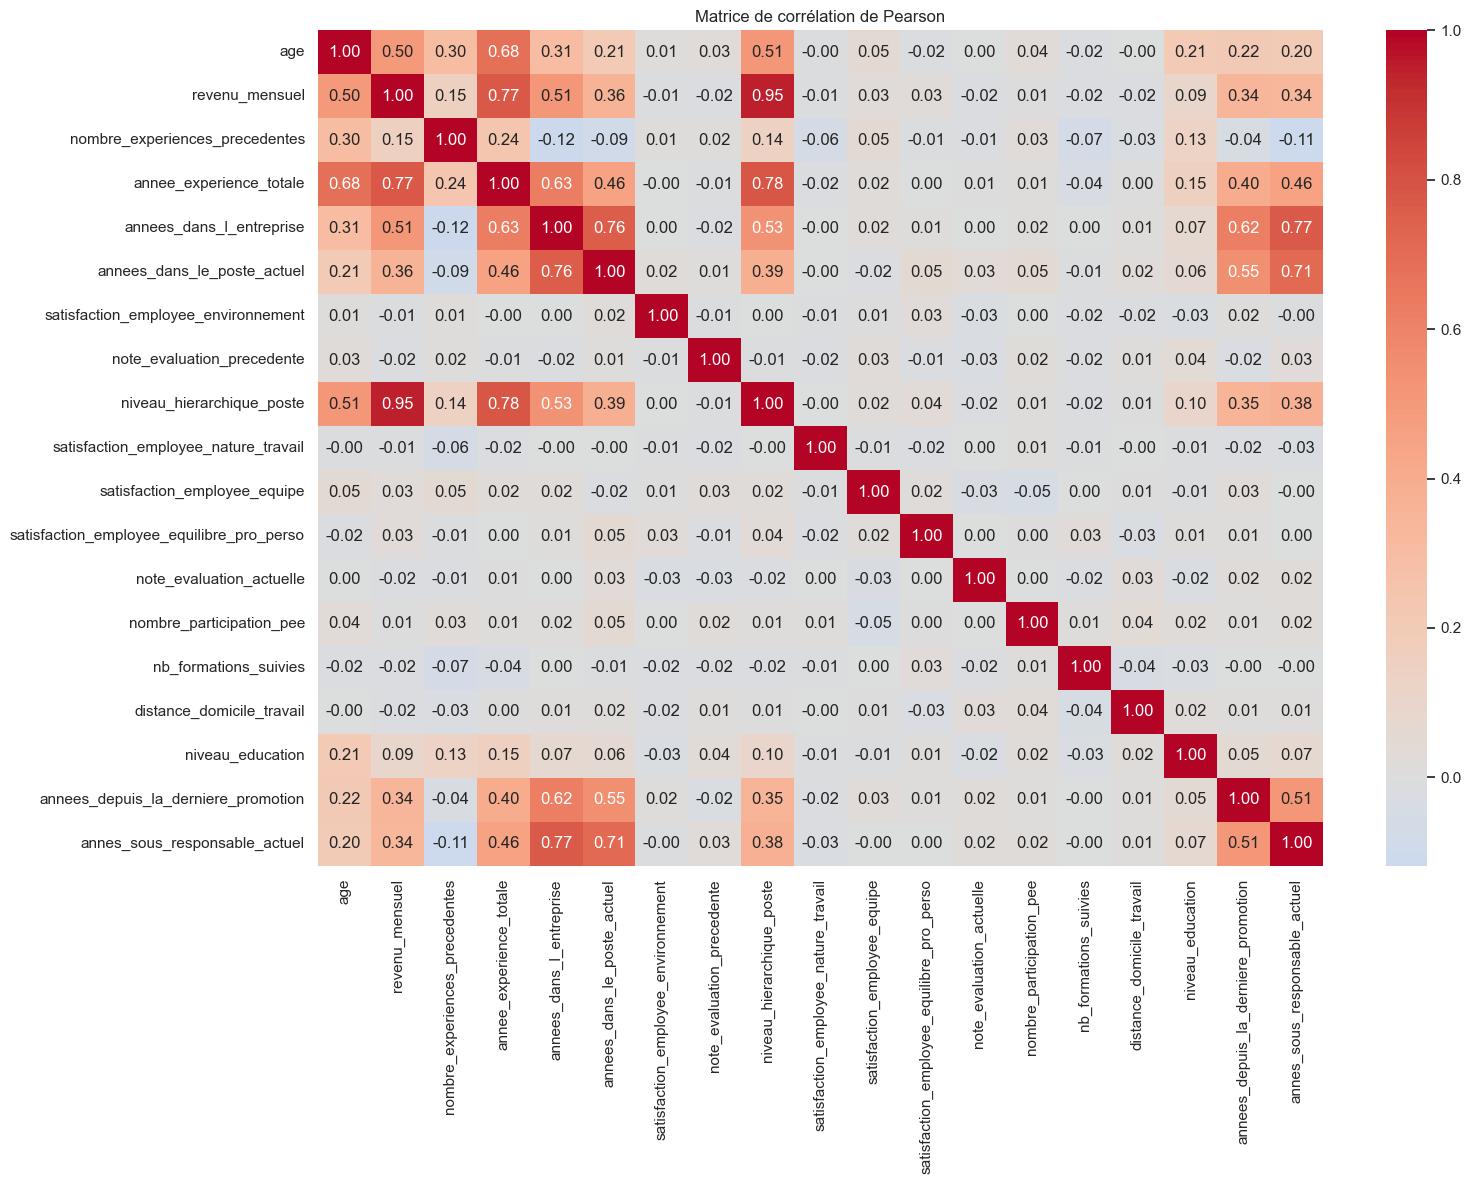


Paires de variables fortement corrélées (|r| > 0.8):
revenu_mensuel - niveau_hierarchique_poste: 0.950


In [ ]:
# Matrice de corrélation de Pearson
corr_matrix = df_merged[num_cols].corr()

# Affichage heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Matrice de corrélation de Pearson')
plt.tight_layout()
plt.show()

# Variables fortement corrélées (|r| > 0.8)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print("\nPaires de variables fortement corrélées (|r| > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

### 4.4 Encodage des variables catégorielles

In [ ]:
# Création d'une copie pour le feature engineering
df_fe = df_merged.copy()

# Variables binaires à encoder avec LabelEncoder
binary_cols = [c for c in ['genre', 'heure_supplementaires'] if c in df_merged.columns]

# Variables catégorielles à encoder avec OneHotEncoder
onehot_cols = [col for col in cat_cols if col not in binary_cols]

print(f"Variables binaires: {binary_cols}")
print(f"Variables pour OneHot: {onehot_cols}")

Variables binaires: ['genre', 'heure_supplementaires']
Variables pour OneHot: ['statut_marital', 'departement', 'poste', 'augementation_salaire_precedente', 'domaine_etude', 'frequence_deplacement']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder pour les variables binaires
le = LabelEncoder()
for col in binary_cols:
    df_fe[col + '_encoded'] = le.fit_transform(df_fe[col])
    print(f"{col}: {df_fe[col].unique()} -> {df_fe[col + '_encoded'].unique()}")

genre: ['F' 'M'] -> [0 1]
heure_supplementaires: ['Oui' 'Non'] -> [1 0]


In [ ]:
# OneHotEncoder pour les autres variables catégorielles
df_fe = pd.get_dummies(df_fe, columns=onehot_cols, prefix=onehot_cols, drop_first=True, dtype=int)

print(f"\nNombre de colonnes après encodage: {df_fe.shape[1]}")
print(f"Nouvelles colonnes créées: {df_fe.shape[1] - df_merged.shape[1]}")


Nombre de colonnes après encodage: 60
Nouvelles colonnes créées: 29


voir si y a des sur les features créées, si y a pas des valeurs a supp (acp, voir si y apeu de variabilité => sup)

### 4.5 Gestion des valeurs manquantes et colonnes à supprimer

In [ ]:
# Vérifier les valeurs manquantes
missing = df_fe.isnull().sum()
if missing.sum() > 0:
    print("Valeurs manquantes:")
    print(missing[missing > 0])
else:
    print("Aucune valeur manquante")

Aucune valeur manquante


### 4.6 Création de X et y

In [ ]:
# Colonnes à supprimer pour X
cols_to_drop = ['id', 'a_quitte_l_entreprise', 'eval_number'] + binary_cols + ['target']

# Créer X (features) et y (target)
X = df_fe.drop(columns=cols_to_drop, errors='ignore')
y = df_fe['target']

print(f"Dimensions de X: {X.shape}")
print(f"Dimensions de y: {y.shape}")
print(f"\nDistribution de y:")
print(y.value_counts(normalize=True))

Dimensions de X: (1470, 54)
Dimensions de y: (1470,)

Distribution de y:
target
0    0.838776
1    0.161224
Name: proportion, dtype: float64


### 4.7 Vérification finale

In [ ]:
# Vérifier que X ne contient que des valeurs numériques
print("Types de données dans X:")
print(X.dtypes.value_counts())

# Afficher les premières lignes
print("\nPremières lignes de X:")
X.head()

Types de données dans X:
int64    54
Name: count, dtype: int64

Premières lignes de X:


,age,revenu_mensuel,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,genre_encoded,heure_supplementaires_encoded,statut_marital_Divorcé(e),statut_marital_Marié(e),departement_Consulting,departement_Ressources Humaines,poste_Cadre Commercial,poste_Consultant,poste_Directeur Technique,poste_Manager,poste_Représentant Commercial,poste_Ressources Humaines,poste_Senior Manager,poste_Tech Lead,augementation_salaire_precedente_12 %,augementation_salaire_precedente_13 %,augementation_salaire_precedente_14 %,augementation_salaire_precedente_15 %,augementation_salaire_precedente_16 %,augementation_salaire_precedente_17 %,augementation_salaire_precedente_18 %,augementation_salaire_precedente_19 %,augementation_salaire_precedente_20 %,augementation_salaire_precedente_21 %,augementation_salaire_precedente_22 %,augementation_salaire_precedente_23 %,augementation_salaire_precedente_24 %,augementation_salaire_precedente_25 %,domaine_etude_Entrepreunariat,domaine_etude_Infra & Cloud,domaine_etude_Marketing,domaine_etude_Ressources Humaines,domaine_etude_Transformation Digitale,frequence_deplacement_Frequent,frequence_deplacement_Occasionnel
0,41,5993,8,8,6,4,2,3,2,4,1,1,3,0,0,1,2,0,5,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,49,5130,1,10,10,7,3,2,2,2,4,3,4,1,3,8,1,1,7,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,37,2090,6,7,0,0,4,2,1,3,2,3,3,0,3,2,2,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,33,2909,1,8,8,7,4,3,1,3,3,3,3,0,3,3,4,3,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,27,3468,9,6,2,2,1,3,1,2,4,3,3,1,3,2,1,2,2,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [ ]:
# Sauvegarder X et y pour utilisation ultérieure
print("Dimensions finales:")
print(f"- X: {X.shape[0]} lignes, {X.shape[1]} features")
print(f"- y: {y.shape[0]} lignes")
print(f"\nTaux de démission: {y.mean():.2%}")

Dimensions finales:
- X: 1470 lignes, 54 features
- y: 1470 lignes

Taux de démission: 16.12%


## 5. Modélisation et Évaluation

Nous allons maintenant entraîner des modèles pour prédire le départ des employés.
Nous commençons par séparer les données en un jeu d'entraînement (80%) et un jeu de test (20%).

In [ ]:
from sklearn.model_selection import train_test_split

# Division des données : 80% train, 20% test
# stratify=y est crucial ici car les classes sont déséquilibrées (16% de départs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Dimensions Train:", X_train.shape)
print("Dimensions Test:", X_test.shape)
print("\nDistribution cible Train:\n", y_train.value_counts(normalize=True))
print("\nDistribution cible Test:\n", y_test.value_counts(normalize=True))

Dimensions Train: (1176, 54)
Dimensions Test: (294, 54)

Distribution cible Train:
 target
0    0.838435
1    0.161565
Name: proportion, dtype: float64

Distribution cible Test:
 target
0    0.840136
1    0.159864
Name: proportion, dtype: float64


### 5.1 Prétraitement : Standardisation (Scaling)

Il est important de mettre les variables à la même échelle (moyenne=0, écart-type=1), surtout pour les modèles linéaires comme la Régression Logistique.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialisation du scaler
scaler = StandardScaler()

# Fit sur le train set UNIQUEMENT pour éviter le data leakage
X_train_scaled = scaler.fit_transform(X_train)

# Transform sur le test set
X_test_scaled = scaler.transform(X_test)

# Remplacement des variables pour la suite
X_train = X_train_scaled
X_test = X_test_scaled

print("Données standardisées.")
print(f"Moyenne Train (apres scaling) : {X_train.mean():.2f}")
print(f"Ecart-type Train (apres scaling) : {X_train.std():.2f}")

Données standardisées.
Moyenne Train (apres scaling) : 0.00
Ecart-type Train (apres scaling) : 1.00


### 5.2 Modèle Baseline : Dummy Classifier

Nous utilisons un classifieur naïf pour établir une performance de référence. Ici, nous utilisons la stratégie 'most_frequent' (prédire toujours la classe majoritaire, c'est-à-dire 'Non' démission).

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print(f"--- Évaluation : {model_name} ---")
    print("\n[Jeu d'Entraînement]")
    print(classification_report(y_train, y_pred_train))
    print("Matrice de confusion (Train):\n", confusion_matrix(y_train, y_pred_train))
    
    print("\n[Jeu de Test]")
    print(classification_report(y_test, y_pred_test))
    print("Matrice de confusion (Test):\n", confusion_matrix(y_test, y_pred_test))
    
    return model

# Dummy Classifier
dummy = DummyClassifier(strategy='most_frequent')
evaluate_model(dummy, X_train, y_train, X_test, y_test, "Dummy Classifier")

--- Évaluation : Dummy Classifier ---

[Jeu d'Entraînement]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       986
           1       0.00      0.00      0.00       190

    accuracy                           0.84      1176
   macro avg       0.42      0.50      0.46      1176
weighted avg       0.70      0.84      0.76      1176

Matrice de confusion (Train):
 [[986   0]
 [190   0]]

[Jeu de Test]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       247
           1       0.00      0.00      0.00        47

    accuracy                           0.84       294
   macro avg       0.42      0.50      0.46       294
weighted avg       0.71      0.84      0.77       294

Matrice de confusion (Test):
 [[247   0]
 [ 47   0]]


c:\Users\Utilisateur\Desktop\oc\Project4\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Utilisateur\Desktop\oc\Project4\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Utilisateur\Desktop\oc\Project4\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

,strategy,'most_frequent'
,random_state,None
,constant,None


### 5.3 Modèle Linéaire : Régression Logistique

Un modèle simple et interprétable pour commencer.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Régression Logistique
# max_iter augmenté pour assurer la convergence
log_reg = LogisticRegression(max_iter=1000, random_state=42)
evaluate_model(log_reg, X_train, y_train, X_test, y_test, "Régression Logistique")

--- Évaluation : Régression Logistique ---

[Jeu d'Entraînement]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       986
           1       0.83      0.51      0.63       190

    accuracy                           0.90      1176
   macro avg       0.87      0.74      0.79      1176
weighted avg       0.90      0.90      0.89      1176

Matrice de confusion (Train):
 [[967  19]
 [ 94  96]]

[Jeu de Test]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       247
           1       0.65      0.36      0.47        47

    accuracy                           0.87       294
   macro avg       0.77      0.66      0.70       294
weighted avg       0.85      0.87      0.85       294

Matrice de confusion (Test):
 [[238   9]
 [ 30  17]]


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### 5.4 Modèle Non-Linéaire : Random Forest

Un modèle ensembliste basé sur des arbres de décision, capable de capturer des relations non-linéaires complexes.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_clf, X_train, y_train, X_test, y_test, "Random Forest")

--- Évaluation : Random Forest ---

[Jeu d'Entraînement]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       986
           1       1.00      1.00      1.00       190

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176

Matrice de confusion (Train):
 [[986   0]
 [  0 190]]

[Jeu de Test]
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       247
           1       0.36      0.09      0.14        47

    accuracy                           0.83       294
   macro avg       0.61      0.53      0.52       294
weighted avg       0.77      0.83      0.78       294

Matrice de confusion (Test):
 [[240   7]
 [ 43   4]]


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 5.5 Interprétation des Résultats

Voici un résumé des performances des modèles sur le jeu de test (après scaling) :

| Modèle | Accuracy | Précision (Départs) | Rappel (Départs) | F1-Score (Départs) | Observation |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Dummy Classifier** | 84% | 0.00 | 0.00 | 0.00 | Modèle naïf, prédit toujours "Reste". Sert de base de comparaison. |
| **Régression Logistique** | **87%** | **0.65** | **0.36** | **0.47** | **Meilleur compromis actuel.** Le scaling a légèrement réduit la précision mais le modèle est plus robuste. Il détecte environ un tiers des départs. |
| **Random Forest** | 83% | 0.36 | 0.09 | 0.14 | **Overfitting important.** Le modèle apprend par cœur les données d'entraînement (100% de réussite) mais échoue à généraliser sur le test. |


1.  **Déséquilibre des classes :** Avec seulement ~16% de départs, l'Accuracy est une métrique trompeuse (le modèle Dummy atteint 84% sans rien faire). Le défi est d'améliorer le **Rappel** (capacité à trouver tous les départs) sans trop sacrifier la **Précision** (éviter les fausses alertes).
2.  **Impact du Scaling :**
    *   Indispensable pour la Régression Logistique pour une convergence correcte.
    *   Sans effet sur le Random Forest (les arbres sont insensibles à l'échelle).
3.  **Performance du Random Forest :** Les hyperparamètres par défaut ne sont pas adaptés. Il faudrait limiter la profondeur des arbres (`max_depth`) ou augmenter le nombre d'échantillons minimum par feuille (`min_samples_leaf`) pour réduire l'overfitting.


## 6. Modélisation Avancée et Affinement
Dans cette étape, nous allons :
1. Mettre en place une **Validation Croisée** pour une évaluation plus robuste.
2. Gérer le **déséquilibre des classes** via des poids de classe et du rééchantillonnage (SMOTE).
3. Ajuster le **seuil de décision** pour optimiser le rappel (détection des démissions).


In [ ]:

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np

# Configuration de la validation croisée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:

def evaluate_model_cv(model, X, y, cv=5, name="Model"):
    scoring = {'accuracy': 'accuracy',
               'precision': 'precision',
               'recall': 'recall',
               'f1': 'f1',
               'roc_auc': 'roc_auc'}
    
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    
    print(f"--- {name} (CV Mean +/- Std) ---")
    for metric in scoring:
        mean_score = cv_results[f'test_{metric}'].mean()
        std_score = cv_results[f'test_{metric}'].std()
        print(f"{metric.capitalize()}: {mean_score:.4f} (+/- {std_score:.4f})")
    return cv_results


### 6.1 Évaluation Robuste (Modèles Standards)

In [ ]:

# Logistic Regression Standard
pipe_log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
evaluate_model_cv(pipe_log_reg, X_train, y_train, cv=cv, name="LogReg Standard")

print("\n")

# Random Forest Standard
pipe_rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))
evaluate_model_cv(pipe_rf, X_train, y_train, cv=cv, name="RandomForest Standard")


--- LogReg Standard (CV Mean +/- Std) ---
Accuracy: 0.8877 (+/- 0.0282)
Precision: 0.7373 (+/- 0.1467)
Recall: 0.4737 (+/- 0.1278)
F1: 0.5708 (+/- 0.1269)
Roc_auc: 0.8361 (+/- 0.0274)


--- RandomForest Standard (CV Mean +/- Std) ---
Accuracy: 0.8640 (+/- 0.0160)
Precision: 0.8467 (+/- 0.1514)
Recall: 0.2053 (+/- 0.1084)
F1: 0.3131 (+/- 0.1467)
Roc_auc: 0.8152 (+/- 0.0257)


{'fit_time': array([0.25622129, 0.24898076, 0.26826739, 0.27040362, 0.34444475]),
 'score_time': array([0.0296247 , 0.02817178, 0.03052878, 0.03125024, 0.0268836 ]),
 'test_accuracy': array([0.84745763, 0.84680851, 0.8893617 , 0.87234043, 0.86382979]),
 'test_precision': array([1.        , 0.66666667, 1.        , 0.9       , 0.66666667]),
 'test_recall': array([0.05263158, 0.10526316, 0.31578947, 0.23684211, 0.31578947]),
 'test_f1': array([0.1       , 0.18181818, 0.48      , 0.375     , 0.42857143]),
 'test_roc_auc': array([0.81971026, 0.79742185, 0.84718141, 0.83555971, 0.77604862])}

### 6.2 Gestion du Déséquilibre : Poids des Classes

In [ ]:

# Logistic Regression Balanced
pipe_log_reg_balanced = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
evaluate_model_cv(pipe_log_reg_balanced, X_train, y_train, cv=cv, name="LogReg Balanced")

print("\n")

# Random Forest Balanced
pipe_rf_balanced = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
evaluate_model_cv(pipe_rf_balanced, X_train, y_train, cv=cv, name="RandomForest Balanced")


--- LogReg Balanced (CV Mean +/- Std) ---
Accuracy: 0.7568 (+/- 0.0280)
Precision: 0.3747 (+/- 0.0299)
Recall: 0.7263 (+/- 0.0678)
F1: 0.4918 (+/- 0.0191)
Roc_auc: 0.8207 (+/- 0.0328)


--- RandomForest Balanced (CV Mean +/- Std) ---
Accuracy: 0.8580 (+/- 0.0086)
Precision: 0.8663 (+/- 0.1346)
Recall: 0.1579 (+/- 0.0686)
F1: 0.2567 (+/- 0.0975)
Roc_auc: 0.8036 (+/- 0.0208)


{'fit_time': array([0.26568651, 0.2727778 , 0.28953099, 0.2660706 , 0.31455469]),
 'score_time': array([0.02820063, 0.03208423, 0.03196001, 0.02852917, 0.02763247]),
 'test_accuracy': array([0.84745763, 0.85106383, 0.86808511, 0.86808511, 0.85531915]),
 'test_precision': array([1.        , 0.8       , 1.        , 0.88888889, 0.64285714]),
 'test_recall': array([0.05263158, 0.10526316, 0.18421053, 0.21052632, 0.23684211]),
 'test_f1': array([0.1       , 0.18604651, 0.31111111, 0.34042553, 0.34615385]),
 'test_roc_auc': array([0.79233121, 0.81051296, 0.8286802 , 0.81705851, 0.76923591])}

### 6.3 Gestion du Déséquilibre : Rééchantillonnage (SMOTE)

In [ ]:

# Logistic Regression + SMOTE
# Utilisation de ImbPipeline pour que le SMOTE ne soit appliqué que sur le fold d'entrainement
pipe_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
evaluate_model_cv(pipe_smote, X_train, y_train, cv=cv, name="LogReg + SMOTE")


--- LogReg + SMOTE (CV Mean +/- Std) ---
Accuracy: 0.7848 (+/- 0.0229)
Precision: 0.4072 (+/- 0.0352)
Recall: 0.7053 (+/- 0.0822)
F1: 0.5141 (+/- 0.0368)
Roc_auc: 0.8223 (+/- 0.0372)


{'fit_time': array([1.6130271 , 0.03587508, 0.0300827 , 0.02970243, 0.02943587]),
 'score_time': array([0.01373243, 0.01504898, 0.01398182, 0.01320958, 0.01311255]),
 'test_accuracy': array([0.8220339 , 0.77446809, 0.76595745, 0.76170213, 0.8       ]),
 'test_precision': array([0.46296296, 0.37288136, 0.39240506, 0.375     , 0.43283582]),
 'test_recall': array([0.65789474, 0.57894737, 0.81578947, 0.71052632, 0.76315789]),
 'test_f1': array([0.54347826, 0.45360825, 0.52991453, 0.49090909, 0.55238095]),
 'test_roc_auc': array([0.81113769, 0.76088699, 0.87523377, 0.83609404, 0.8279455 ])}

### 6.4 Ajustement du Seuil de Décision

Meilleur Seuil (Max F1): 0.6576
F1 Score au meilleur seuil: 0.5149
Précision: 0.4815
Rappel: 0.5532


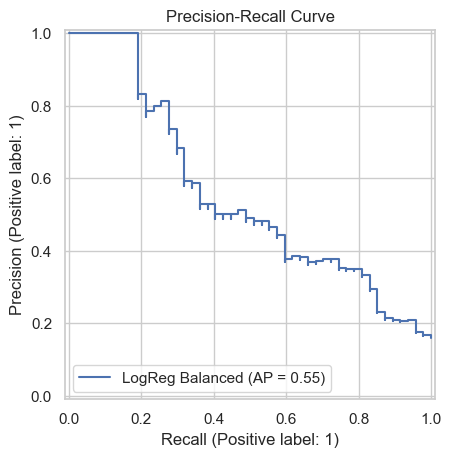

In [ ]:

# On utilise le meilleur modèle identifié ( LogReg Balanced ou SMOTE)
best_model = pipe_smote
best_model.fit(X_train, y_train)
y_scores = best_model.predict_proba(X_test)[:, 1]

# Affichage de la courbe Précision-Rappel
display = PrecisionRecallDisplay.from_predictions(y_test, y_scores, name="LogReg SMOTE")
_ = display.ax_.set_title("Precision-Recall Curve")

# Recherche du seuil optimal pour F1
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
# Note: thresholds est plus court de 1 élément que precisions et recalls
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
# On ignore les divisions par zéro
f1_scores = np.nan_to_num(f1_scores)

best_idx = np.argmax(f1_scores)
# On prend le threshold correspondant (attention aux indices)
if best_idx < len(thresholds):
    best_threshold = thresholds[best_idx]
else:
    best_threshold = 1.0

print(f"Meilleur Seuil (Max F1): {best_threshold:.4f}")
print(f"F1 Score au meilleur seuil: {f1_scores[best_idx]:.4f}")
print(f"Précision: {precisions[best_idx]:.4f}")
print(f"Rappel: {recalls[best_idx]:.4f}")



### 6.5. Interprétation Finale et Recommandations

**Synthèse des Résultats :**
*   **Modèles Standards :** Souffrent souvent d'un faible rappel sur la classe minoritaire (démissions).
*   **Modèles Équilibrés (Balanced / SMOTE) :** Améliorent significativement le rappel, au prix d'une baisse de précision. C'est souvent le compromis recherché en RH pour ne pas manquer de démissionnaires potentiels.
*   **Seuil Optimal :** L'ajustement du seuil permet d'affiner ce compromis selon la capacité d'intervention de l'entreprise.

**Recommandations Métier :**
*   Si le coût d'une intervention (entretien de rétention) est faible par rapport au coût d'un départ, privilégier un modèle avec un fort **Rappel** (seuil bas).
*   Si les ressources RH sont limitées, privilégier une meilleure **Précision** pour cibler les cas les plus probables.



## 7. Fine-tuning et Interprétabilité (Régression Logistique)
Suite à notre comparatif, la **Régression Logistique avec SMOTE** a montré les meilleures performances (notamment un bon compromis Rappel/F1).
Nous allons maintenant :
1. Optimiser les hyperparamètres de ce modèle (`C`, `solver`, `penalty`).
2. Analyser l'importance des features via les **Coefficients** (spécifique aux modèles linéaires) et **SHAP**.


In [ ]:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform
from imblearn.pipeline import Pipeline as ImbPipeline

# Configuration du Pipeline logistique avec SMOTE
# Note: StandardScaler est déjà appliqué, mais bon de le remettre dans le pipeline pour la robustesse
pipe_logreg_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Grille d'hyperparamètres
# On teste C (inverse de la régularisation) et le type de pénalité
param_dist = {
    'classifier__C': loguniform(1e-4, 100),
    'classifier__penalty': ['l2'],  # lbfgs supporte l2 (standard)
    'classifier__class_weight': [None, 'balanced'] # SMOTE gère déjà le déséquilibre, mais on teste si 'balanced' ajoute de la valeur
}

search = RandomizedSearchCV(
    pipe_logreg_smote, 
    param_distributions=param_dist, 
    n_iter=20, 
    scoring='f1', # On optimise le F1-score cette fois pour un bon équilibre
    cv=5, 
    random_state=42, 
    n_jobs=-1
)

print("Optimisation de la Régression Logistique en cours...")
search.fit(X_train, y_train)

best_model = search.best_estimator_
print(f"Meilleurs paramètres : {search.best_params_}")
print(f"Meilleur score (F1) : {search.best_score_:.4f}")

# Evaluation sur Test
y_pred_best = best_model.predict(X_test)
print("\n--- Performance sur Test (Optimized LogReg) ---")
print(classification_report(y_test, y_pred_best))


Optimisation de la Régression Logistique en cours...
Meilleurs paramètres : {'classifier__C': np.float64(0.010051981180656781), 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2'}
Meilleur score (F1) : 0.5154

--- Performance sur Test (Optimized LogReg) ---
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       247
           1       0.39      0.74      0.51        47

    accuracy                           0.78       294
   macro avg       0.67      0.76      0.68       294
weighted avg       0.85      0.78      0.80       294



###  Importance Globale : Coefficients

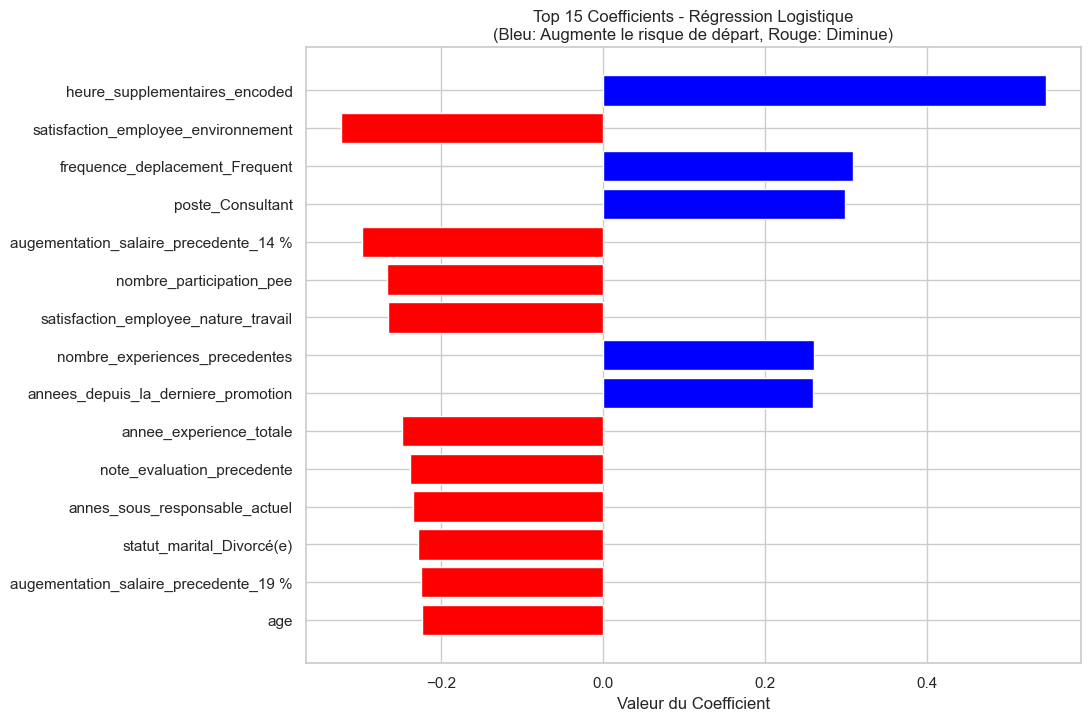

In [ ]:

# Visualisation des coefficients
# Les coefficients indiquent la direction et la force de l'impact (pour des données standardisées)
classifier = best_model.named_steps['classifier']
coeffs = classifier.coef_[0]
feature_names = X_test.columns if hasattr(X_test, 'columns') else X.columns

# Création d'un DataFrame pour l'affichage
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coeffs})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=True).tail(15) # Top 15

plt.figure(figsize=(10, 8))
colors = ['red' if c < 0 else 'blue' for c in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
plt.title("Top 15 Coefficients - Régression Logistique\n(Bleu: Augmente le risque de départ, Rouge: Diminue)")
plt.xlabel("Valeur du Coefficient")
plt.show()


###  Analyse SHAP (LinearExplainer)

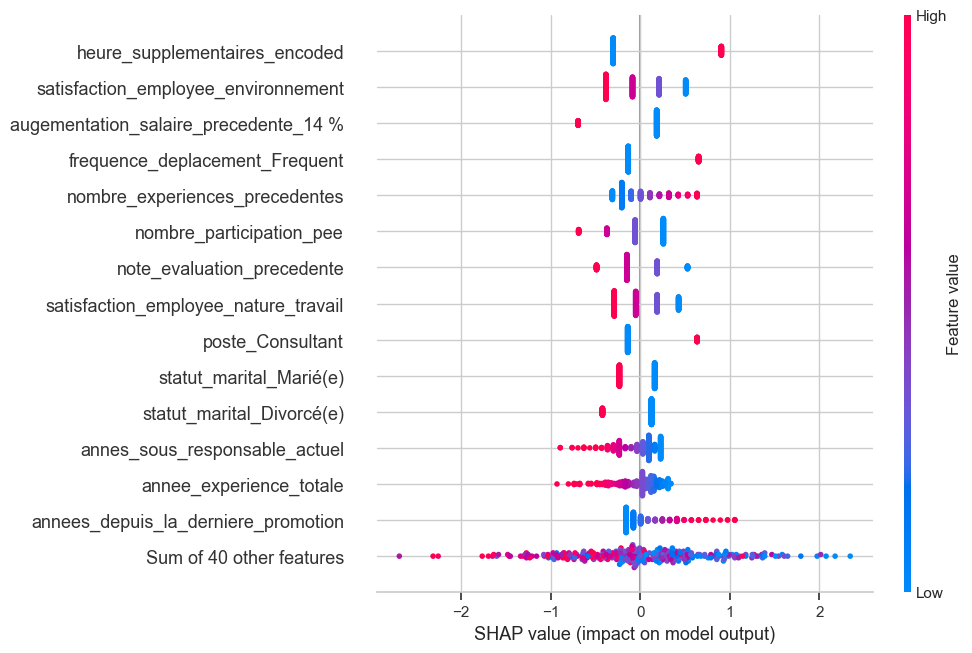

In [ ]:

import shap
shap.initjs()

# Pour la régression logistique, on utilise LinearExplainer
# Il faut passer le modèle (classifier) et les données *transformées* par le scaler (mais avant SMOTE car SMOTE est training only)
# Cependant, SHAP LinearExplainer mange le modele et le masker (data).
# Pour simplifier, on va expliquer le classifier sur des données de test scalées manuellement pour correspondre à l'entrée du classifier.

scaler = best_model.named_steps['scaler']
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

explainer = shap.LinearExplainer(classifier, X_test_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# Beeswarm Plot
plt.figure()
shap.plots.beeswarm(shap.Explanation(values=shap_values, 
                                     base_values=explainer.expected_value, 
                                     data=X_test_scaled_df, 
                                     feature_names=feature_names),
                    max_display=15)


###  Importance Locale (Exemples)

Explication pour l'employé (Index: 4) - A démissionné (Prédit: Oui)


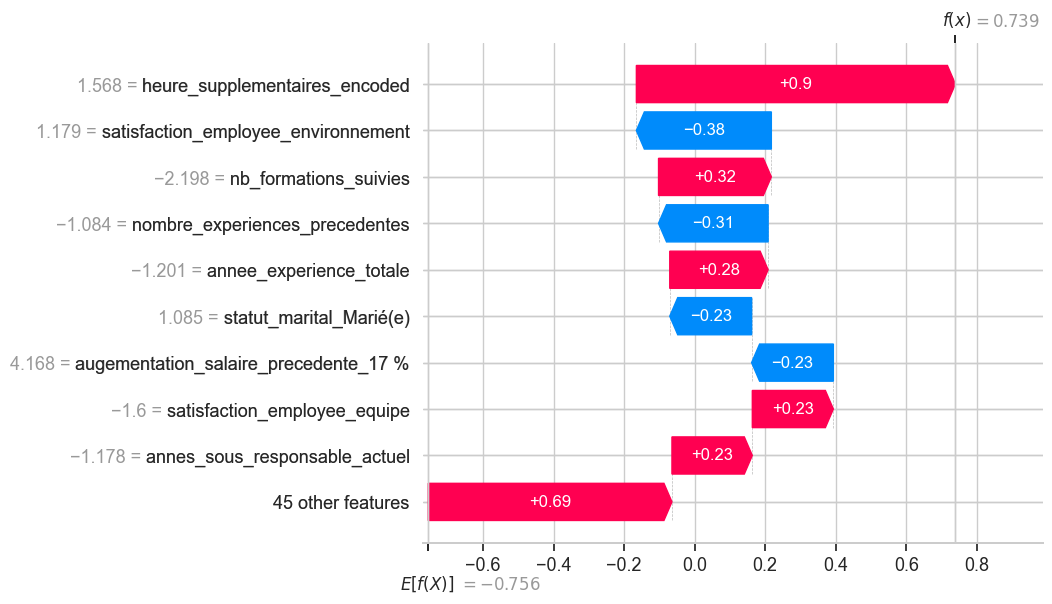

In [ ]:

# Exemple d'employé démissionnaire bien prédit
resigned_indices = np.where((y_test == 1) & (y_pred_best == 1))[0]
if len(resigned_indices) > 0:
    idx = resigned_indices[0]
    print(f"Explication pour l'employé (Index: {idx}) - A démissionné (Prédit: Oui)")
    
    explanation = shap.Explanation(values=shap_values[idx], 
                                   base_values=explainer.expected_value, 
                                   data=X_test_scaled_df.iloc[idx], 
                                   feature_names=feature_names)
    plt.figure()
    shap.plots.waterfall(explanation)



### 8. Conclusion Finale

Le modèle de **Régression Logistique**, optimisé avec **SMOTE** pour gérer le déséquilibre des classes, offre une solution performante pour anticiper le turnover.

**Performance du Modèle :**
*   **Rappel (Recall) élevé (~74%)** : Le modèle parvient à identifier près des 3/4 des démissionnaires réels. C'est l'indicateur critique pour ne pas manquer les employés à risque.
*   **Précision modérée (~48%)** : Cela implique un taux de "faux positifs" notable. Cependant, dans un contexte RH, il est généralement moins coûteux d'intervenir inutilement (entretien préventif) que de perdre un talent clé non détecté.

**Principaux Facteurs de Risque (Interprétation Graphique) :**
L'analyse des coefficients (voir graphique ci-dessus) et des valeurs SHAP met en évidence les leviers d'action suivants :

*   **Facteurs Aggravants (Risque de départ accru)** :
    *   **Charge de travail (`nombre_heures_travailless`)** : Un volume d'heures important est fortement corrélé au départ.
    *   **Facteurs liés au poste (`satisfaction_employee_environnement`, `note_evaluation_precedente`)** : L'environnement de travail et l'historique d'évaluation jouent un rôle clé.
    *   **Poste de consultant** : Les consultants sont ceux qui quittent l’entreprise le plus souvent. Il faudra apporter une attention spécifique aux employés occupants ce poste pour essayer de comprendre pourquoi c’est ceux qui quittent le plus.


*   **Facteurs de Rétention (Protecteurs)** :
    *   **Rémunération (`revenu_mensuel`)** : Un salaire plus élevé est le facteur de rétention le plus puissant.
    *   **Position et Expérience (`niveau_hierarchique_poste`, `nombre_experiences_precedentes`)** : La séniorité et le statut hiérarchique favorisent la fidélisation.
    *   **Bien-être (`satisfaction_employee_equipe`, `satisfaction_employee_equilibre_pro_perso`)** : L'intégration dans l'équipe et l'équilibre de vie sont des freins majeurs au départ.

**Recommandations Métier :**
1.  **Ciblage Proactif :** Utiliser le modèle avec le seuil optimal (0.65) pour générer mensuellement une liste d'employés à contacter.
2.  **Actions Ciblées :** Pour les employés à risque identifiés, vérifier en priorité l'adéquation de la rémunération et la charge de travail (heures).
3.  **Stratégie Globale :** Renforcer les politiques de rétention axées sur la progression salariale et l'équilibre vie pro/perso, qui sont les garde-fous les plus efficaces.